# Import Libraries

In [0]:
from __future__ import print_function
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms

## Data Transformations

We first start with defining our data transformations. We need to think what our data is and how can we augment it to correct represent images which it might not see otherwise. 


In [0]:
# Train Phase transformations
train_transforms = transforms.Compose([
                                       #  transforms.Resize((28, 28)),
                                       #  transforms.ColorJitter(brightness=0.10, contrast=0.1, saturation=0.10, hue=0.1),
                                       transforms.ToTensor(),
                                       transforms.Normalize((0.1307,), (0.3081,)) # The mean and std have to be sequences (e.g., tuples), therefore you should add a comma after the values. 
                                       # Note the difference between (0.1307) and (0.1307,)
                                       ])

# Test Phase transformations
test_transforms = transforms.Compose([
                                      #  transforms.Resize((28, 28)),
                                      #  transforms.ColorJitter(brightness=0.10, contrast=0.1, saturation=0.10, hue=0.1),
                                       transforms.ToTensor(),
                                       transforms.Normalize((0.1307,), (0.3081,))
                                       ])


# Dataset and Creating Train/Test Split

In [0]:
train = datasets.MNIST('./data', train=True, download=True, transform=train_transforms)
test = datasets.MNIST('./data', train=False, download=True, transform=test_transforms)


Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw



Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw



Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw



Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw
Processing...
Done!


# Dataloader Arguments & Test/Train Dataloaders


In [0]:
SEED = 1

# CUDA?
cuda = torch.cuda.is_available()
print("CUDA Available?", cuda)

# For reproducibility
torch.manual_seed(SEED)

if cuda:
    torch.cuda.manual_seed(SEED)

# dataloader arguments - something you'll fetch these from cmdprmt
dataloader_args = dict(shuffle=True, batch_size=128, num_workers=4, pin_memory=True) if cuda else dict(shuffle=True, batch_size=64)

# train dataloader
train_loader = torch.utils.data.DataLoader(train, **dataloader_args)

# test dataloader
test_loader = torch.utils.data.DataLoader(test, **dataloader_args)

CUDA Available? True
CUDA Available? True


# Data Statistics

It is important to know your data very well. Let's check some of the statistics around our data and how it actually looks like

/usr/local/lib/python3.6/dist-packages/torchvision/datasets/mnist.py:55: UserWarning: train_data has been renamed data
  warnings.warn("train_data has been renamed data")


[Train]
 - Numpy Shape: (60000, 28, 28)
 - Tensor Shape: torch.Size([60000, 28, 28])
 - min: tensor(-0.4242)
 - max: tensor(2.8215)
 - mean: tensor(0.0009)
 - std: tensor(1.0000)
 - var: tensor(1.0001)
torch.Size([128, 1, 28, 28])
torch.Size([128])


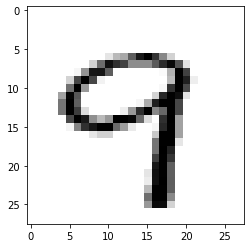

/usr/local/lib/python3.6/dist-packages/torchvision/datasets/mnist.py:55: UserWarning: train_data has been renamed data
  warnings.warn("train_data has been renamed data")


[Train]
 - Numpy Shape: (60000, 28, 28)
 - Tensor Shape: torch.Size([60000, 28, 28])
 - min: tensor(-0.4242)
 - max: tensor(2.8215)
 - mean: tensor(0.0009)
 - std: tensor(1.0000)
 - var: tensor(1.0001)
torch.Size([128, 1, 28, 28])
torch.Size([128])


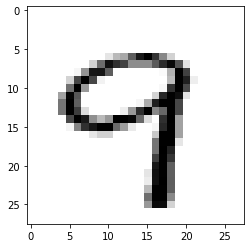

In [0]:
# We'd need to convert it into Numpy! Remember above we have converted it into tensors already
train_data = train.train_data
train_data = train.transform(train_data.numpy())

print('[Train]')
print(' - Numpy Shape:', train.train_data.cpu().numpy().shape)
print(' - Tensor Shape:', train.train_data.size())
print(' - min:', torch.min(train_data))
print(' - max:', torch.max(train_data))
print(' - mean:', torch.mean(train_data))
print(' - std:', torch.std(train_data))
print(' - var:', torch.var(train_data))

dataiter = iter(train_loader)
images, labels = dataiter.next()

print(images.shape)
print(labels.shape)

# Let's visualize some of the images
%matplotlib inline
import matplotlib.pyplot as plt

plt.imshow(images[0].numpy().squeeze(), cmap='gray_r')


## MORE

It is important that we view as many images as possible. This is required to get some idea on image augmentation later on

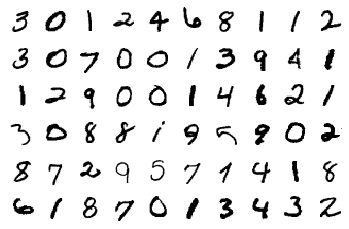

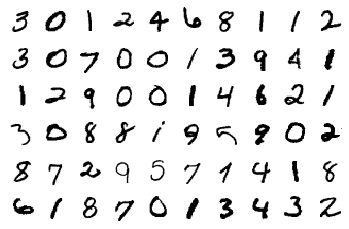

In [0]:
figure = plt.figure()
num_of_images = 60
for index in range(1, num_of_images + 1):
    plt.subplot(6, 10, index)
    plt.axis('off')
    plt.imshow(images[index].numpy().squeeze(), cmap='gray_r')

# The model
Let's start with the model we first saw

In [0]:
dropout_value = 0
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        # Input Block
        self.convblock1 = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=16, kernel_size=(3, 3), padding=0, bias=False),
            nn.ReLU(),
            nn.BatchNorm2d(16),
            nn.Dropout(dropout_value)
        ) # output_size = 26  Rf 3 Jout - 1

        # CONVOLUTION BLOCK 1
        self.convblock2 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=32, kernel_size=(3, 3), padding=0, bias=False),  #32
            nn.ReLU(),
            nn.BatchNorm2d(32),
            nn.Dropout(dropout_value)
        ) # output_size = 24 RF 5 Jout -1

        self.convblock3 = nn.Sequential(
            nn.Conv2d(in_channels=32, out_channels=10, kernel_size=(1, 1), padding=0, bias=False),    #32
            
        ) 

        # TRANSITION BLOCK 1
        self.pool1 = nn.MaxPool2d(2, 2) # output_size = 12  RF 6 Jout - 2


        self.convblock4 = nn.Sequential(
            nn.Conv2d(in_channels=10, out_channels=16, kernel_size=(3, 3), padding=0, bias=False),
            nn.ReLU(),
            nn.BatchNorm2d(16),
            nn.Dropout(dropout_value)
        ) # output_size =10  RF 10 Jout - 2


        # CONVOLUTION BLOCK 2
        self.convblock5 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=16, kernel_size=(3, 3), padding=0, bias=False),
            nn.ReLU(),
            nn.BatchNorm2d(16),
            nn.Dropout(dropout_value)
        ) # output_size = 8  RF -14 ,Jout - 2

        #self.convblock6 = nn.Sequential(
        #    nn.Conv2d(in_channels=16, out_channels=16, kernel_size=(3, 3), padding=0, bias=False),
        #   nn.ReLU(),
        #   nn.BatchNorm2d(16),
        #   nn.Dropout(dropout_value)
        #) # output_size = 6 RF - 18  Jout - 2

        # OUTPUT BLOCK
        self.gap = nn.Sequential(
            nn.AvgPool2d(kernel_size=8)
        ) # output_size = 1

        self.convblock7 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=10, kernel_size=(1, 1), padding=0, bias=False),
            
        ) 


    def forward(self, x):
        x = self.convblock1(x)
        x = self.convblock2(x)
        x = self.convblock3(x)
        x = self.pool1(x)
        x = self.convblock4(x)
        x = self.convblock5(x)
       # x = self.convblock6(x)
        x = self.gap(x)        
        x = self.convblock7(x)
        x = x.view(-1, 10)
        return F.log_softmax(x, dim=-1)

# Model Params
Can't emphasize on how important viewing Model Summary is. 
Unfortunately, there is no in-built model visualizer, so we have to take external help

In [0]:
!pip install torchsummary
from torchsummary import summary
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
print(device)
model = Net().to(device)
summary(model, input_size=(1, 28, 28))

cuda
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 16, 26, 26]             144
              ReLU-2           [-1, 16, 26, 26]               0
       BatchNorm2d-3           [-1, 16, 26, 26]              32
           Dropout-4           [-1, 16, 26, 26]               0
            Conv2d-5           [-1, 32, 24, 24]           4,608
              ReLU-6           [-1, 32, 24, 24]               0
       BatchNorm2d-7           [-1, 32, 24, 24]              64
           Dropout-8           [-1, 32, 24, 24]               0
            Conv2d-9           [-1, 10, 24, 24]             320
        MaxPool2d-10           [-1, 10, 12, 12]               0
           Conv2d-11           [-1, 16, 10, 10]           1,440
             ReLU-12           [-1, 16, 10, 10]               0
      BatchNorm2d-13           [-1, 16, 10, 10]              32
          Dropout-14           [-1

# Training and Testing

Looking at logs can be boring, so we'll introduce **tqdm** progressbar to get cooler logs. 

Let's write train and test functions

In [0]:
from tqdm import tqdm
train_losses = []
test_losses = []
train_acc = []
test_acc = []


def train(model, device, train_loader, optimizer, epoch,is_L1):
  model.train()
  pbar = tqdm(train_loader)
  correct = 0
  processed = 0
  for batch_idx, (data, target) in enumerate(pbar):
    # get samples
    data, target = data.to(device), target.to(device)

    # Init
    optimizer.zero_grad()
    # In PyTorch, we need to set the gradients to zero before starting to do backpropragation because PyTorch accumulates the gradients on subsequent backward passes. 
    # Because of this, when you start your training loop, ideally you should zero out the gradients so that you do the parameter update correctly.

    # Predict
    y_pred = model(data)

    # Calculate loss
    loss = F.nll_loss(y_pred, target)
    ##Adding code for L1 Regularisation
    if(is_L1==True):
      
      l1_crit = nn.L1Loss(size_average=False)
      reg_loss = 0
      for param in model.parameters():
          reg_loss += l1_crit(param,target=torch.zeros_like(param))

      factor = 0.0005
      loss += factor * reg_loss
      train_losses.append(loss)

    else:
      train_losses.append(loss)

    # Backpropagation
    loss.backward()
    optimizer.step()

    # Update pbar-tqdm
    
    pred = y_pred.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
    correct += pred.eq(target.view_as(pred)).sum().item()
    processed += len(data)

    pbar.set_description(desc= f'Loss={loss.item()} Batch_id={batch_idx} Accuracy={100*correct/processed:0.2f}')
    train_acc.append(100*correct/processed)

def test(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0

    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)
    test_losses.append(test_loss)

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))
    
    test_acc.append(100. * correct / len(test_loader.dataset))
    #return(test_acc,test_loss)

# Let's Train and test our model

In [0]:
def train_model(is_L1,is_L2):
  model =  Net().to(device)
  
  if(is_L2==True):
    optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9,weight_decay=0.003)
  else:
    optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
  EPOCHS = 40
  for epoch in range(EPOCHS):
      print("EPOCH:", epoch)
      train(model, device, train_loader, optimizer, epoch,is_L1)
      test(model, device, test_loader)
  
  #return(test_acc,test_losses)

a1=train_model(is_L1=False,is_L2=False)
a2=train_model(is_L1=True,is_L2=False)
a3=train_model(is_L1=False,is_L2=True)
a4=train_model(is_L1=True,is_L2=True)

  0%|          | 0/469 [00:00<?, ?it/s]

EPOCH: 0


Loss=0.2481352686882019 Batch_id=468 Accuracy=85.15: 100%|██████████| 469/469 [00:11<00:00, 48.57it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.1998, Accuracy: 9486/10000 (94.86%)

EPOCH: 1


Loss=0.09352138638496399 Batch_id=468 Accuracy=97.19: 100%|██████████| 469/469 [00:11<00:00, 45.32it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0885, Accuracy: 9775/10000 (97.75%)

EPOCH: 2


Loss=0.05977843329310417 Batch_id=468 Accuracy=98.01: 100%|██████████| 469/469 [00:11<00:00, 41.23it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0656, Accuracy: 9818/10000 (98.18%)

EPOCH: 3


Loss=0.14888596534729004 Batch_id=468 Accuracy=98.29: 100%|██████████| 469/469 [00:11<00:00, 42.16it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0959, Accuracy: 9709/10000 (97.09%)

EPOCH: 4


Loss=0.030544036999344826 Batch_id=468 Accuracy=98.55: 100%|██████████| 469/469 [00:11<00:00, 42.11it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0542, Accuracy: 9832/10000 (98.32%)

EPOCH: 5


Loss=0.03500216081738472 Batch_id=468 Accuracy=98.65: 100%|██████████| 469/469 [00:11<00:00, 40.85it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0519, Accuracy: 9850/10000 (98.50%)

EPOCH: 6


Loss=0.05432293191552162 Batch_id=468 Accuracy=98.80: 100%|██████████| 469/469 [00:11<00:00, 41.76it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0447, Accuracy: 9865/10000 (98.65%)

EPOCH: 7


Loss=0.017170384526252747 Batch_id=468 Accuracy=98.93: 100%|██████████| 469/469 [00:11<00:00, 41.39it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0437, Accuracy: 9860/10000 (98.60%)

EPOCH: 8


Loss=0.02165328525006771 Batch_id=468 Accuracy=98.97: 100%|██████████| 469/469 [00:13<00:00, 34.82it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0427, Accuracy: 9869/10000 (98.69%)

EPOCH: 9


Loss=0.020132025703787804 Batch_id=468 Accuracy=99.06: 100%|██████████| 469/469 [00:11<00:00, 46.11it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0337, Accuracy: 9902/10000 (99.02%)

EPOCH: 10


Loss=0.04547886177897453 Batch_id=468 Accuracy=99.09: 100%|██████████| 469/469 [00:12<00:00, 38.49it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0482, Accuracy: 9838/10000 (98.38%)

EPOCH: 11


Loss=0.039314981549978256 Batch_id=468 Accuracy=99.19: 100%|██████████| 469/469 [00:11<00:00, 46.87it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0372, Accuracy: 9881/10000 (98.81%)

EPOCH: 12


Loss=0.006985703948885202 Batch_id=468 Accuracy=99.23: 100%|██████████| 469/469 [00:11<00:00, 45.46it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0403, Accuracy: 9875/10000 (98.75%)

EPOCH: 13


Loss=0.015457252971827984 Batch_id=468 Accuracy=99.28: 100%|██████████| 469/469 [00:11<00:00, 40.49it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0372, Accuracy: 9879/10000 (98.79%)

EPOCH: 14


Loss=0.06781446933746338 Batch_id=468 Accuracy=99.33: 100%|██████████| 469/469 [00:11<00:00, 40.88it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0345, Accuracy: 9888/10000 (98.88%)

EPOCH: 15


Loss=0.029736801981925964 Batch_id=468 Accuracy=99.36: 100%|██████████| 469/469 [00:11<00:00, 40.68it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0343, Accuracy: 9886/10000 (98.86%)

EPOCH: 16


Loss=0.01503609586507082 Batch_id=468 Accuracy=99.37: 100%|██████████| 469/469 [00:11<00:00, 41.84it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0335, Accuracy: 9880/10000 (98.80%)

EPOCH: 17


Loss=0.015503992326557636 Batch_id=468 Accuracy=99.37: 100%|██████████| 469/469 [00:10<00:00, 45.24it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0294, Accuracy: 9895/10000 (98.95%)

EPOCH: 18


Loss=0.015273024328052998 Batch_id=468 Accuracy=99.46: 100%|██████████| 469/469 [00:11<00:00, 42.59it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0381, Accuracy: 9874/10000 (98.74%)

EPOCH: 19


Loss=0.014649863354861736 Batch_id=468 Accuracy=99.40: 100%|██████████| 469/469 [00:12<00:00, 38.11it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0312, Accuracy: 9906/10000 (99.06%)

EPOCH: 20


Loss=0.06205323711037636 Batch_id=468 Accuracy=99.47: 100%|██████████| 469/469 [00:13<00:00, 33.76it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0298, Accuracy: 9897/10000 (98.97%)

EPOCH: 21


Loss=0.032896775752305984 Batch_id=468 Accuracy=99.50: 100%|██████████| 469/469 [00:11<00:00, 40.82it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0301, Accuracy: 9895/10000 (98.95%)

EPOCH: 22


Loss=0.011543904431164265 Batch_id=468 Accuracy=99.51: 100%|██████████| 469/469 [00:11<00:00, 40.85it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0310, Accuracy: 9899/10000 (98.99%)

EPOCH: 23


Loss=0.037422943860292435 Batch_id=468 Accuracy=99.53: 100%|██████████| 469/469 [00:11<00:00, 40.94it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0314, Accuracy: 9906/10000 (99.06%)

EPOCH: 24


Loss=0.010194201953709126 Batch_id=468 Accuracy=99.56: 100%|██████████| 469/469 [00:11<00:00, 41.33it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0294, Accuracy: 9900/10000 (99.00%)

EPOCH: 25


Loss=0.052054498344659805 Batch_id=468 Accuracy=99.54: 100%|██████████| 469/469 [00:11<00:00, 41.48it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0280, Accuracy: 9910/10000 (99.10%)

EPOCH: 26


Loss=0.010226677171885967 Batch_id=468 Accuracy=99.58: 100%|██████████| 469/469 [00:11<00:00, 43.03it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0334, Accuracy: 9899/10000 (98.99%)

EPOCH: 27


Loss=0.03877495974302292 Batch_id=468 Accuracy=99.61: 100%|██████████| 469/469 [00:10<00:00, 44.09it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0310, Accuracy: 9905/10000 (99.05%)

EPOCH: 28


Loss=0.010881314985454082 Batch_id=468 Accuracy=99.59: 100%|██████████| 469/469 [00:11<00:00, 42.61it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0282, Accuracy: 9916/10000 (99.16%)

EPOCH: 29


Loss=0.0021897554397583008 Batch_id=468 Accuracy=99.67: 100%|██████████| 469/469 [00:10<00:00, 44.75it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0303, Accuracy: 9903/10000 (99.03%)

EPOCH: 30


Loss=0.0018154779681935906 Batch_id=468 Accuracy=99.66: 100%|██████████| 469/469 [00:10<00:00, 43.90it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0326, Accuracy: 9894/10000 (98.94%)

EPOCH: 31


Loss=0.007450411561876535 Batch_id=468 Accuracy=99.65: 100%|██████████| 469/469 [00:10<00:00, 44.16it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0298, Accuracy: 9902/10000 (99.02%)

EPOCH: 32


Loss=0.015554025769233704 Batch_id=468 Accuracy=99.67: 100%|██████████| 469/469 [00:10<00:00, 44.87it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0308, Accuracy: 9901/10000 (99.01%)

EPOCH: 33


Loss=0.028513744473457336 Batch_id=468 Accuracy=99.70: 100%|██████████| 469/469 [00:10<00:00, 42.90it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0283, Accuracy: 9908/10000 (99.08%)

EPOCH: 34


Loss=0.025620946660637856 Batch_id=468 Accuracy=99.71: 100%|██████████| 469/469 [00:10<00:00, 44.20it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0299, Accuracy: 9914/10000 (99.14%)

EPOCH: 35


Loss=0.006345570087432861 Batch_id=468 Accuracy=99.70: 100%|██████████| 469/469 [00:10<00:00, 43.38it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0287, Accuracy: 9913/10000 (99.13%)

EPOCH: 36


Loss=0.00878879427909851 Batch_id=468 Accuracy=99.74: 100%|██████████| 469/469 [00:10<00:00, 43.52it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0289, Accuracy: 9905/10000 (99.05%)

EPOCH: 37


Loss=0.03210347518324852 Batch_id=468 Accuracy=99.73: 100%|██████████| 469/469 [00:10<00:00, 43.80it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0295, Accuracy: 9911/10000 (99.11%)

EPOCH: 38


Loss=0.013888701796531677 Batch_id=468 Accuracy=99.71: 100%|██████████| 469/469 [00:10<00:00, 43.19it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0268, Accuracy: 9912/10000 (99.12%)

EPOCH: 39


Loss=0.010471448302268982 Batch_id=468 Accuracy=99.78: 100%|██████████| 469/469 [00:10<00:00, 43.65it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0318, Accuracy: 9894/10000 (98.94%)

EPOCH: 0


/usr/local/lib/python3.6/dist-packages/torch/nn/_reduction.py:43: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
Loss=0.36765599250793457 Batch_id=468 Accuracy=81.44: 100%|██████████| 469/469 [00:11<00:00, 39.77it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.1753, Accuracy: 9640/10000 (96.40%)

EPOCH: 1


Loss=0.3661172688007355 Batch_id=468 Accuracy=97.16: 100%|██████████| 469/469 [00:11<00:00, 39.88it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.1176, Accuracy: 9709/10000 (97.09%)

EPOCH: 2


Loss=0.276891827583313 Batch_id=468 Accuracy=97.77: 100%|██████████| 469/469 [00:11<00:00, 40.22it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0728, Accuracy: 9803/10000 (98.03%)

EPOCH: 3


Loss=0.24436205625534058 Batch_id=468 Accuracy=97.94: 100%|██████████| 469/469 [00:11<00:00, 39.98it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0938, Accuracy: 9725/10000 (97.25%)

EPOCH: 4


Loss=0.21680636703968048 Batch_id=468 Accuracy=98.09: 100%|██████████| 469/469 [00:11<00:00, 41.17it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.1696, Accuracy: 9467/10000 (94.67%)

EPOCH: 5


Loss=0.19151675701141357 Batch_id=468 Accuracy=98.11: 100%|██████████| 469/469 [00:11<00:00, 40.70it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0774, Accuracy: 9768/10000 (97.68%)

EPOCH: 6


Loss=0.19869886338710785 Batch_id=468 Accuracy=98.28: 100%|██████████| 469/469 [00:11<00:00, 39.24it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0728, Accuracy: 9782/10000 (97.82%)

EPOCH: 7


Loss=0.1893562376499176 Batch_id=468 Accuracy=98.21: 100%|██████████| 469/469 [00:11<00:00, 39.18it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0901, Accuracy: 9727/10000 (97.27%)

EPOCH: 8


Loss=0.2104690819978714 Batch_id=468 Accuracy=98.32: 100%|██████████| 469/469 [00:11<00:00, 41.09it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0582, Accuracy: 9839/10000 (98.39%)

EPOCH: 9


Loss=0.17585010826587677 Batch_id=468 Accuracy=98.41: 100%|██████████| 469/469 [00:11<00:00, 40.25it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0528, Accuracy: 9847/10000 (98.47%)

EPOCH: 10


Loss=0.21641570329666138 Batch_id=468 Accuracy=98.31: 100%|██████████| 469/469 [00:11<00:00, 40.26it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0737, Accuracy: 9777/10000 (97.77%)

EPOCH: 11


Loss=0.21653974056243896 Batch_id=468 Accuracy=98.38: 100%|██████████| 469/469 [00:11<00:00, 40.43it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0650, Accuracy: 9823/10000 (98.23%)

EPOCH: 12


Loss=0.1970876306295395 Batch_id=468 Accuracy=98.38: 100%|██████████| 469/469 [00:11<00:00, 39.64it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0576, Accuracy: 9823/10000 (98.23%)

EPOCH: 13


Loss=0.22198079526424408 Batch_id=468 Accuracy=98.42: 100%|██████████| 469/469 [00:11<00:00, 41.61it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0486, Accuracy: 9852/10000 (98.52%)

EPOCH: 14


Loss=0.22148725390434265 Batch_id=468 Accuracy=98.36: 100%|██████████| 469/469 [00:11<00:00, 40.20it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0875, Accuracy: 9743/10000 (97.43%)

EPOCH: 15


Loss=0.24122990667819977 Batch_id=468 Accuracy=98.40: 100%|██████████| 469/469 [00:11<00:00, 40.10it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0616, Accuracy: 9820/10000 (98.20%)

EPOCH: 16


Loss=0.21550194919109344 Batch_id=468 Accuracy=98.47: 100%|██████████| 469/469 [00:11<00:00, 40.70it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0957, Accuracy: 9711/10000 (97.11%)

EPOCH: 17


Loss=0.17487037181854248 Batch_id=468 Accuracy=98.51: 100%|██████████| 469/469 [00:11<00:00, 40.27it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.1045, Accuracy: 9657/10000 (96.57%)

EPOCH: 18


Loss=0.18105295300483704 Batch_id=468 Accuracy=98.39: 100%|██████████| 469/469 [00:11<00:00, 39.49it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0499, Accuracy: 9866/10000 (98.66%)

EPOCH: 19


Loss=0.18362344801425934 Batch_id=468 Accuracy=98.50: 100%|██████████| 469/469 [00:11<00:00, 40.96it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0505, Accuracy: 9840/10000 (98.40%)

EPOCH: 20


Loss=0.16466544568538666 Batch_id=468 Accuracy=98.55: 100%|██████████| 469/469 [00:11<00:00, 41.11it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.1342, Accuracy: 9571/10000 (95.71%)

EPOCH: 21


Loss=0.1685706377029419 Batch_id=468 Accuracy=98.56: 100%|██████████| 469/469 [00:11<00:00, 40.30it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0601, Accuracy: 9823/10000 (98.23%)

EPOCH: 22


Loss=0.16520436108112335 Batch_id=468 Accuracy=98.58: 100%|██████████| 469/469 [00:11<00:00, 39.91it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0702, Accuracy: 9796/10000 (97.96%)

EPOCH: 23


Loss=0.15772175788879395 Batch_id=468 Accuracy=98.56: 100%|██████████| 469/469 [00:12<00:00, 38.75it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0513, Accuracy: 9847/10000 (98.47%)

EPOCH: 24


Loss=0.17822715640068054 Batch_id=468 Accuracy=98.48: 100%|██████████| 469/469 [00:11<00:00, 40.04it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0492, Accuracy: 9877/10000 (98.77%)

EPOCH: 25


Loss=0.16764308512210846 Batch_id=468 Accuracy=98.57: 100%|██████████| 469/469 [00:11<00:00, 40.38it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0550, Accuracy: 9822/10000 (98.22%)

EPOCH: 26


Loss=0.19554337859153748 Batch_id=468 Accuracy=98.60: 100%|██████████| 469/469 [00:11<00:00, 40.32it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0582, Accuracy: 9839/10000 (98.39%)

EPOCH: 27


Loss=0.14767500758171082 Batch_id=468 Accuracy=98.67: 100%|██████████| 469/469 [00:11<00:00, 40.51it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0577, Accuracy: 9814/10000 (98.14%)

EPOCH: 28


Loss=0.1900428980588913 Batch_id=468 Accuracy=98.57: 100%|██████████| 469/469 [00:11<00:00, 48.61it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0727, Accuracy: 9766/10000 (97.66%)

EPOCH: 29


Loss=0.13995732367038727 Batch_id=468 Accuracy=98.57: 100%|██████████| 469/469 [00:17<00:00, 26.16it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0473, Accuracy: 9863/10000 (98.63%)

EPOCH: 30


Loss=0.1926816701889038 Batch_id=468 Accuracy=98.52: 100%|██████████| 469/469 [00:12<00:00, 38.00it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0649, Accuracy: 9803/10000 (98.03%)

EPOCH: 31


Loss=0.21241742372512817 Batch_id=468 Accuracy=98.58: 100%|██████████| 469/469 [00:11<00:00, 40.74it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0811, Accuracy: 9747/10000 (97.47%)

EPOCH: 32


Loss=0.16394072771072388 Batch_id=468 Accuracy=98.58: 100%|██████████| 469/469 [00:11<00:00, 41.14it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0546, Accuracy: 9834/10000 (98.34%)

EPOCH: 33


Loss=0.17369727790355682 Batch_id=468 Accuracy=98.61: 100%|██████████| 469/469 [00:11<00:00, 40.77it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0584, Accuracy: 9820/10000 (98.20%)

EPOCH: 34


Loss=0.22918890416622162 Batch_id=468 Accuracy=98.63: 100%|██████████| 469/469 [00:11<00:00, 47.98it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0634, Accuracy: 9810/10000 (98.10%)

EPOCH: 35


Loss=0.15363898873329163 Batch_id=468 Accuracy=98.56: 100%|██████████| 469/469 [00:11<00:00, 41.29it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0692, Accuracy: 9801/10000 (98.01%)

EPOCH: 36


Loss=0.18349966406822205 Batch_id=468 Accuracy=98.56: 100%|██████████| 469/469 [00:11<00:00, 40.03it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0855, Accuracy: 9725/10000 (97.25%)

EPOCH: 37


Loss=0.13919338583946228 Batch_id=468 Accuracy=98.62: 100%|██████████| 469/469 [00:11<00:00, 40.29it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0777, Accuracy: 9764/10000 (97.64%)

EPOCH: 38


Loss=0.17152008414268494 Batch_id=468 Accuracy=98.54: 100%|██████████| 469/469 [00:11<00:00, 40.91it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0663, Accuracy: 9801/10000 (98.01%)

EPOCH: 39


Loss=0.2019398808479309 Batch_id=468 Accuracy=98.59: 100%|██████████| 469/469 [00:11<00:00, 40.16it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0578, Accuracy: 9837/10000 (98.37%)

EPOCH: 0


Loss=0.080544613301754 Batch_id=468 Accuracy=81.64: 100%|██████████| 469/469 [00:10<00:00, 45.29it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.1750, Accuracy: 9665/10000 (96.65%)

EPOCH: 1


Loss=0.11469972133636475 Batch_id=468 Accuracy=97.20: 100%|██████████| 469/469 [00:10<00:00, 43.73it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.1257, Accuracy: 9731/10000 (97.31%)

EPOCH: 2


Loss=0.11168710142374039 Batch_id=468 Accuracy=97.84: 100%|██████████| 469/469 [00:10<00:00, 43.61it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0982, Accuracy: 9794/10000 (97.94%)

EPOCH: 3


Loss=0.05888723209500313 Batch_id=468 Accuracy=98.05: 100%|██████████| 469/469 [00:10<00:00, 43.99it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0955, Accuracy: 9785/10000 (97.85%)

EPOCH: 4


Loss=0.16027365624904633 Batch_id=468 Accuracy=98.30: 100%|██████████| 469/469 [00:10<00:00, 43.55it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0819, Accuracy: 9809/10000 (98.09%)

EPOCH: 5


Loss=0.05404067039489746 Batch_id=468 Accuracy=98.34: 100%|██████████| 469/469 [00:10<00:00, 45.42it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0819, Accuracy: 9808/10000 (98.08%)

EPOCH: 6


Loss=0.06837037205696106 Batch_id=468 Accuracy=98.33: 100%|██████████| 469/469 [00:10<00:00, 43.39it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0836, Accuracy: 9820/10000 (98.20%)

EPOCH: 7


Loss=0.09068810939788818 Batch_id=468 Accuracy=98.47: 100%|██████████| 469/469 [00:10<00:00, 42.73it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.1089, Accuracy: 9740/10000 (97.40%)

EPOCH: 8


Loss=0.07921095937490463 Batch_id=468 Accuracy=98.48: 100%|██████████| 469/469 [00:10<00:00, 44.18it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0826, Accuracy: 9813/10000 (98.13%)

EPOCH: 9


Loss=0.07577264308929443 Batch_id=468 Accuracy=98.59: 100%|██████████| 469/469 [00:10<00:00, 43.37it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0958, Accuracy: 9750/10000 (97.50%)

EPOCH: 10


Loss=0.06046692654490471 Batch_id=468 Accuracy=98.51: 100%|██████████| 469/469 [00:10<00:00, 45.43it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0731, Accuracy: 9839/10000 (98.39%)

EPOCH: 11


Loss=0.0681971088051796 Batch_id=468 Accuracy=98.56: 100%|██████████| 469/469 [00:10<00:00, 43.92it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0819, Accuracy: 9824/10000 (98.24%)

EPOCH: 12


Loss=0.06682755798101425 Batch_id=468 Accuracy=98.66: 100%|██████████| 469/469 [00:10<00:00, 43.81it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0756, Accuracy: 9835/10000 (98.35%)

EPOCH: 13


Loss=0.09786701947450638 Batch_id=468 Accuracy=98.58: 100%|██████████| 469/469 [00:10<00:00, 43.52it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0924, Accuracy: 9799/10000 (97.99%)

EPOCH: 14


Loss=0.04451775550842285 Batch_id=468 Accuracy=98.64: 100%|██████████| 469/469 [00:10<00:00, 42.85it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0844, Accuracy: 9798/10000 (97.98%)

EPOCH: 15


Loss=0.06338990479707718 Batch_id=468 Accuracy=98.64: 100%|██████████| 469/469 [00:10<00:00, 44.41it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.1026, Accuracy: 9760/10000 (97.60%)

EPOCH: 16


Loss=0.12742216885089874 Batch_id=468 Accuracy=98.62: 100%|██████████| 469/469 [00:10<00:00, 49.17it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0833, Accuracy: 9826/10000 (98.26%)

EPOCH: 17


Loss=0.06490693241357803 Batch_id=468 Accuracy=98.61: 100%|██████████| 469/469 [00:11<00:00, 42.32it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0696, Accuracy: 9860/10000 (98.60%)

EPOCH: 18


Loss=0.0514683723449707 Batch_id=468 Accuracy=98.71: 100%|██████████| 469/469 [00:10<00:00, 43.17it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0778, Accuracy: 9833/10000 (98.33%)

EPOCH: 19


Loss=0.09901690483093262 Batch_id=468 Accuracy=98.67: 100%|██████████| 469/469 [00:10<00:00, 42.87it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0927, Accuracy: 9781/10000 (97.81%)

EPOCH: 20


Loss=0.07832203060388565 Batch_id=468 Accuracy=98.69: 100%|██████████| 469/469 [00:10<00:00, 43.00it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.1112, Accuracy: 9713/10000 (97.13%)

EPOCH: 21


Loss=0.11792028695344925 Batch_id=468 Accuracy=98.65: 100%|██████████| 469/469 [00:10<00:00, 43.13it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.1128, Accuracy: 9754/10000 (97.54%)

EPOCH: 22


Loss=0.0917070284485817 Batch_id=468 Accuracy=98.72: 100%|██████████| 469/469 [00:10<00:00, 42.65it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0929, Accuracy: 9780/10000 (97.80%)

EPOCH: 23


Loss=0.05821073427796364 Batch_id=468 Accuracy=98.65: 100%|██████████| 469/469 [00:10<00:00, 43.40it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0764, Accuracy: 9841/10000 (98.41%)

EPOCH: 24


Loss=0.06199953332543373 Batch_id=468 Accuracy=98.80: 100%|██████████| 469/469 [00:10<00:00, 48.30it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0896, Accuracy: 9811/10000 (98.11%)

EPOCH: 25


Loss=0.04090074449777603 Batch_id=468 Accuracy=98.70: 100%|██████████| 469/469 [00:10<00:00, 43.36it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0765, Accuracy: 9831/10000 (98.31%)

EPOCH: 26


Loss=0.09889531135559082 Batch_id=468 Accuracy=98.71: 100%|██████████| 469/469 [00:10<00:00, 43.98it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0783, Accuracy: 9823/10000 (98.23%)

EPOCH: 27


Loss=0.08989562839269638 Batch_id=468 Accuracy=98.75: 100%|██████████| 469/469 [00:10<00:00, 53.82it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.1094, Accuracy: 9737/10000 (97.37%)

EPOCH: 28


Loss=0.04020100086927414 Batch_id=468 Accuracy=98.74: 100%|██████████| 469/469 [00:11<00:00, 41.25it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0839, Accuracy: 9792/10000 (97.92%)

EPOCH: 29


Loss=0.043110013008117676 Batch_id=468 Accuracy=98.71: 100%|██████████| 469/469 [00:10<00:00, 44.20it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0784, Accuracy: 9845/10000 (98.45%)

EPOCH: 30


Loss=0.07161765545606613 Batch_id=468 Accuracy=98.79: 100%|██████████| 469/469 [00:10<00:00, 43.46it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0828, Accuracy: 9831/10000 (98.31%)

EPOCH: 31


Loss=0.05674092844128609 Batch_id=468 Accuracy=98.75: 100%|██████████| 469/469 [00:10<00:00, 44.72it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0780, Accuracy: 9828/10000 (98.28%)

EPOCH: 32


Loss=0.06132867932319641 Batch_id=468 Accuracy=98.74: 100%|██████████| 469/469 [00:10<00:00, 43.46it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0753, Accuracy: 9861/10000 (98.61%)

EPOCH: 33


Loss=0.06366629153490067 Batch_id=468 Accuracy=98.71: 100%|██████████| 469/469 [00:10<00:00, 49.02it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0586, Accuracy: 9867/10000 (98.67%)

EPOCH: 34


Loss=0.07317113131284714 Batch_id=468 Accuracy=98.76: 100%|██████████| 469/469 [00:10<00:00, 45.30it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0850, Accuracy: 9809/10000 (98.09%)

EPOCH: 35


Loss=0.06343007832765579 Batch_id=468 Accuracy=98.79: 100%|██████████| 469/469 [00:11<00:00, 42.48it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0986, Accuracy: 9787/10000 (97.87%)

EPOCH: 36


Loss=0.08517205715179443 Batch_id=468 Accuracy=98.73: 100%|██████████| 469/469 [00:10<00:00, 50.38it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0680, Accuracy: 9856/10000 (98.56%)

EPOCH: 37


Loss=0.03036832995712757 Batch_id=468 Accuracy=98.76: 100%|██████████| 469/469 [00:10<00:00, 44.01it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.1069, Accuracy: 9729/10000 (97.29%)

EPOCH: 38


Loss=0.06930840760469437 Batch_id=468 Accuracy=98.74: 100%|██████████| 469/469 [00:10<00:00, 43.12it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.1339, Accuracy: 9715/10000 (97.15%)

EPOCH: 39


Loss=0.03741660341620445 Batch_id=468 Accuracy=98.79: 100%|██████████| 469/469 [00:10<00:00, 44.78it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0813, Accuracy: 9823/10000 (98.23%)

EPOCH: 0


Loss=0.5251356363296509 Batch_id=468 Accuracy=83.69: 100%|██████████| 469/469 [00:12<00:00, 39.00it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.2386, Accuracy: 9527/10000 (95.27%)

EPOCH: 1


Loss=0.35790032148361206 Batch_id=269 Accuracy=96.78:  57%|█████▋    | 266/469 [00:06<00:05, 36.40it/s]

Buffered data was truncated after reaching the output size limit.

In [0]:
#fig, axs = plt.subplots(2,2,figsize=(15,10))
#axs[0, 0].plot(train_losses)
#axs[0, 0].set_title("Training Loss")
#axs[1, 0].plot(train_acc)
#axs[1, 0].set_title("Training Accuracy")
#axs[0, 1].plot(test_losses)
#axs[0, 1].set_title("Test Loss")
#axs[1, 1].plot(test_acc)
#axs[1, 1].set_title("Test Accuracy")

In [0]:
print((test_acc))
print((test_losses))

[94.86, 97.75, 98.18, 97.09, 98.32, 98.5, 98.65, 98.6, 98.69, 99.02, 98.38, 98.81, 98.75, 98.79, 98.88, 98.86, 98.8, 98.95, 98.74, 99.06, 98.97, 98.95, 98.99, 99.06, 99.0, 99.1, 98.99, 99.05, 99.16, 99.03, 98.94, 99.02, 99.01, 99.08, 99.14, 99.13, 99.05, 99.11, 99.12, 98.94, 96.4, 97.09, 98.03, 97.25, 94.67, 97.68, 97.82, 97.27, 98.39, 98.47, 97.77, 98.23, 98.23, 98.52, 97.43, 98.2, 97.11, 96.57, 98.66, 98.4, 95.71, 98.23, 97.96, 98.47, 98.77, 98.22, 98.39, 98.14, 97.66, 98.63, 98.03, 97.47, 98.34, 98.2, 98.1, 98.01, 97.25, 97.64, 98.01, 98.37, 96.65, 97.31, 97.94, 97.85, 98.09, 98.08, 98.2, 97.4, 98.13, 97.5, 98.39, 98.24, 98.35, 97.99, 97.98, 97.6, 98.26, 98.6, 98.33, 97.81, 97.13, 97.54, 97.8, 98.41, 98.11, 98.31, 98.23, 97.37, 97.92, 98.45, 98.31, 98.28, 98.61, 98.67, 98.09, 97.87, 98.56, 97.29, 97.15, 98.23, 95.27, 97.24, 95.42, 97.77, 97.96, 97.5, 97.09, 97.85, 95.88, 95.0, 97.87, 97.37, 97.88, 97.42, 97.35, 95.66, 95.69, 97.73, 97.62, 94.92, 98.06, 96.82, 96.33, 95.41, 96.24, 97

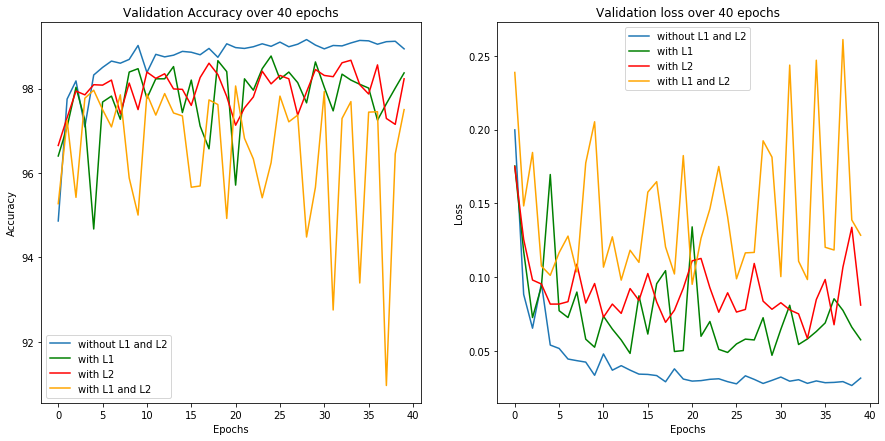

In [0]:
from google.colab import files


fig,(ax1,ax2) = plt.subplots(1,2,figsize=(15,7))
ax1.plot(test_acc[:40], label="without L1 and L2")
ax1.plot(test_acc[40:80], color="green", label="with L1")
ax1.plot(test_acc[80:120], color="red", label="with L2")
ax1.plot(test_acc[120:], color="orange", label="with L1 and L2")
ax1.set_title("Validation Accuracy over 40 epochs")
ax1.set_xlabel('Epochs')
ax1.set_ylabel('Accuracy')
ax1.legend()

extent = ax1.get_window_extent().transformed(fig.dpi_scale_trans.inverted())
fig.savefig('Accuracy_S6.png', bbox_inches=extent.expanded(1.1, 1.2))
files.download("Accuracy_S6.png") 

ax2.plot(test_losses[:40],label="without L1 and L2")
ax2.plot(test_losses[40:80], color="green", label="with L1")
ax2.plot(test_losses[80:120], color="red", label="with L2")
ax2.plot(test_losses[120:], color="orange", label="with L1 and L2")
ax2.set_title("Validation loss over 40 epochs")
ax2.set_xlabel('Epochs')
ax2.set_ylabel('Loss')
ax2.legend()
extent = ax2.get_window_extent().transformed(fig.dpi_scale_trans.inverted())
fig.savefig('Loss_S6.png', bbox_inches=extent.expanded(1.1, 1.2))
files.download("Loss_S6.png") 